In [19]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from nilearn import image
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix, plot_stat_map
from nilearn.interfaces.fmriprep import load_confounds
sys.path.append('..')
from utils.data import Subject, load_participant_list

In [2]:
base_dir = '/home/ubuntu/data/learning-habits'
bids_dir = '/home/ubuntu/data/learning-habits/bids_dataset/derivatives/fmriprep-23.2.1/'

sub_ids = load_participant_list(base_dir)

In [3]:
#subjects = [Subject(base_dir, sub_id, include_modeling=True, include_imaging=True, bids_dir=bids_dir) for sub_id in sub_ids]
subject = Subject(base_dir, '03', include_modeling=True, include_imaging=True, bids_dir=bids_dir)

In [4]:
subject.stimuli

{'stim_assignment': array([8, 3, 5, 6, 4, 2, 7, 1], dtype=uint8),
 'stim_values': array([1, 2, 2, 3, 3, 4, 4, 5])}

In [5]:
run='learning2'
block = getattr(subject, run)

In [6]:
events_df = block.extend_events_df(columns_event={'first_stim': 'first_stim_presentation'})
events_df.head()

,onset,duration,trial_type,trial,first_stim
0,0.013213,0.950854,first_stim_presentation,1,5.0
1,0.964067,1.000000,second_stim_presentation,1,0.0
2,1.964067,1.535713,non_response_feedback,1,0.0
3,3.499780,6.172409,iti,1,0.0
4,9.672189,0.817427,first_stim_presentation,2,6.0


In [7]:
events_df['trial_type'] = events_df.apply(
    lambda row: f"{row['trial_type']}_{int(row['first_stim'])}" if row['trial_type'] == 'first_stim_presentation' else row['trial_type'],
    axis=1
)
events_df.head()

,onset,duration,trial_type,trial,first_stim
0,0.013213,0.950854,first_stim_presentation_5,1,5.0
1,0.964067,1.000000,second_stim_presentation,1,0.0
2,1.964067,1.535713,non_response_feedback,1,0.0
3,3.499780,6.172409,iti,1,0.0
4,9.672189,0.817427,first_stim_presentation_6,2,6.0


# First level

In [8]:
tr = 2.33384
hrf_model = 'spm'
noise_model = 'ar1'
smoothing_fwhm = 5
high_pass = 0.01
motion_type = 'basic'

In [9]:
img_path = subject.img.get(run)
fmri_img = image.load_img(img_path)

In [10]:
confounds, sample_mask  = subject.load_confounds(run, motion_type=motion_type)
confounds.head(2)

,csf,rot_x,rot_y,rot_z,trans_x,trans_y,trans_z,white_matter,cosine00,cosine01,cosine02,cosine03,cosine04
0,6.263116,0.001533,-0.000016,-0.001741,0.142706,-0.067425,0.074285,1.304801,0.066513,0.069474,0.067696,0.068925,0.068753
1,-6.094948,-0.000684,0.000783,-0.001429,0.140555,-0.001415,0.022667,0.100950,0.066509,0.069459,0.067662,0.068866,0.068660


In [11]:
n = fmri_img.shape[-1]
frametimes = np.linspace(tr/2., (n - .5)*tr, n) # from Gilles, checked with nilearn FirstLevelModel

In [12]:
X = make_first_level_design_matrix(frame_times=frametimes,
                                    events=events_df,
                                    hrf_model=hrf_model,
                                    drift_model=None,
                                    high_pass=high_pass,
                                    add_regs=confounds)

/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
response.
  warnings.warn(
/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: trial, first_stim
  warnings.warn(


<Axes: label='conditions', ylabel='scan number'>

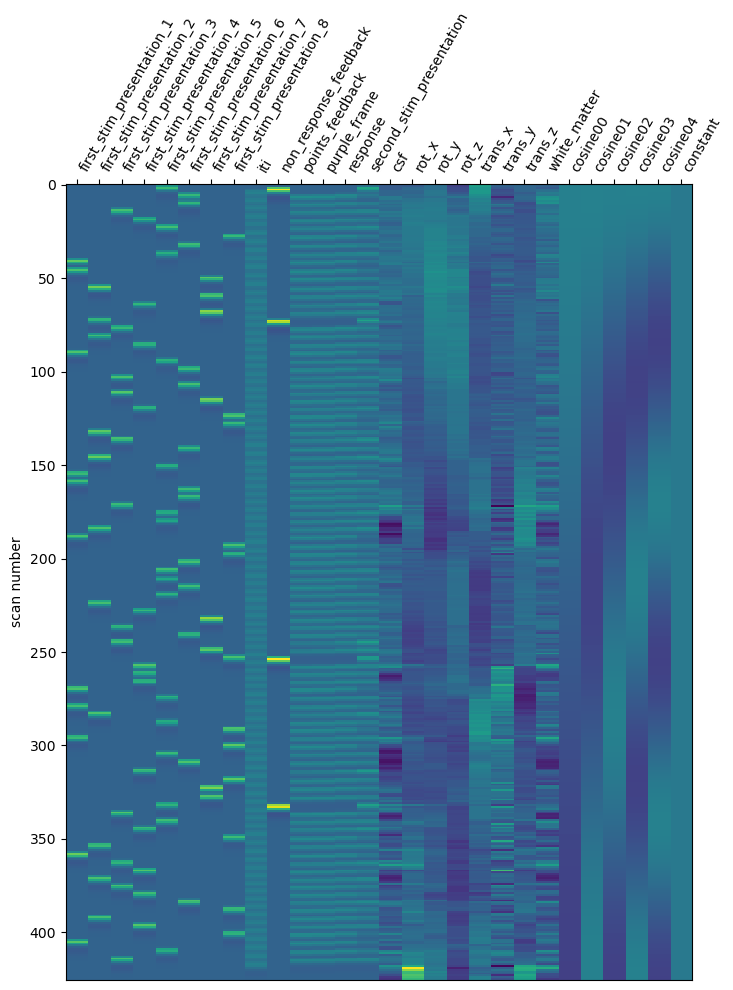

In [13]:
plot_design_matrix(X)

## Optimizing

### Vanilla

In [14]:
model = FirstLevelModel(smoothing_fwhm=smoothing_fwhm)

In [15]:
model_fit = model.fit(fmri_img, design_matrices=X, sample_masks=sample_mask)

In [20]:
# Extract beta maps for each stimulus
stimuli = ['first_stim_presentation_'+ str(i) for i in range(1,9)]
beta_maps = {}
for stim in stimuli:
    beta_map = model_fit.compute_contrast(stim, output_type='z_score')
    beta_maps[stim[-1]] = beta_map
    print(f"Computed beta map for {stim}")

Computed beta map for first_stim_presentation_1
Computed beta map for first_stim_presentation_2
Computed beta map for first_stim_presentation_3
Computed beta map for first_stim_presentation_4
Computed beta map for first_stim_presentation_5
Computed beta map for first_stim_presentation_6
Computed beta map for first_stim_presentation_7
Computed beta map for first_stim_presentation_8


In [21]:
from sklearn.metrics import pairwise_distances

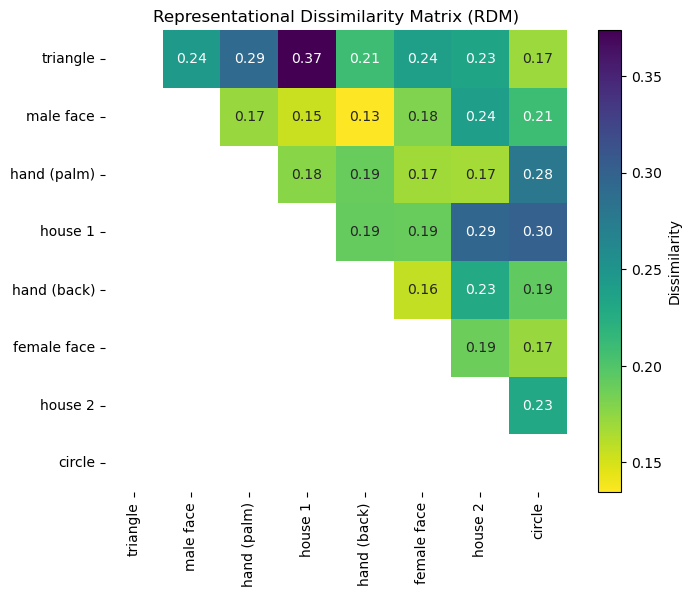

In [41]:
# Extract activation patterns
activation_patterns = np.array([beta_maps[cond].get_fdata().flatten() for cond in beta_maps.keys()])
condition_labels = list(beta_maps.keys())

# Compute the Representational Dissimilarity Matrix (RDM)
rdm = pairwise_distances(activation_patterns, metric='correlation')  # Use 'euclidean' or 'correlation'

# Set the diagonal to NaN
np.fill_diagonal(rdm, np.nan)

# Mask the upper triangle
mask = np.tril(np.ones_like(rdm, dtype=bool))

# Visualize the RDM
plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    rdm, 
    mask=mask,
    xticklabels=[stim_names[i-1] for i in subject.stimuli['stim_assignment']], 
    yticklabels=[stim_names[i-1] for i in subject.stimuli['stim_assignment']], 
    cmap='viridis_r', 
    square=True,
    cbar=False,  # Disable seaborn's default colorbar
    annot=True, fmt=".2f"
)

# Add a single labeled colorbar
colorbar = plt.colorbar(ax.collections[0], label="Dissimilarity")
plt.title("Representational Dissimilarity Matrix (RDM)")
plt.show()

In [31]:
stim_names = ['circle',
              'female face',
              'male face',
              'hand (back)',
              'hand (palm)',
              'house 1',
              'house 2',
              'triangle']

In [32]:
[stim_names[i-1] for i in subject.stimuli['stim_assignment']]


['triangle',
 'male face',
 'hand (palm)',
 'house 1',
 'hand (back)',
 'female face',
 'house 2',
 'circle']

In [ ]:
subject.stimuli['stim_assignment']

array([8, 3, 5, 6, 4, 2, 7, 1], dtype=uint8)